In [14]:
pip install torch torchvision Dataloader Subset transforms torch.utils data

  Preparing metadata (setup.py) ... done
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7226 sha256=2a2837b7c8160194227a81e1b613145c0644acc04089b9713c2169666d4a81f8
  Stored in directory: /root/.cache/pip/wheels/0e/90/87/0e55006f5c69af278687927041e334cfb928ab0a7ad9b0c1a3
Successfully built data


Counts per digitL: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
Batch x shape: torch.Size([128, 1, 14, 14])
Unique Pixel values: tensor([0., 1.])
Labels example: tensor([2, 3, 9, 4, 6, 4, 3, 3, 0, 1])


100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


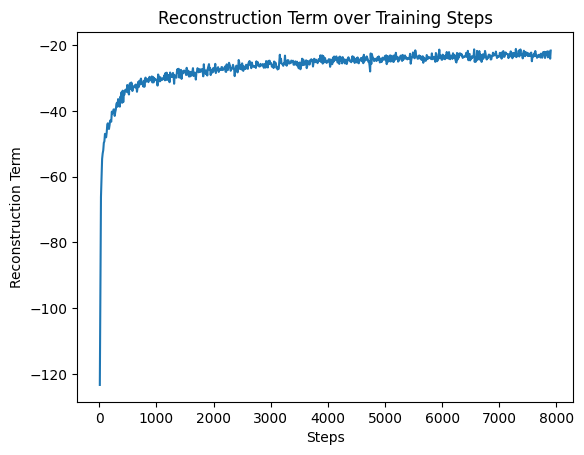

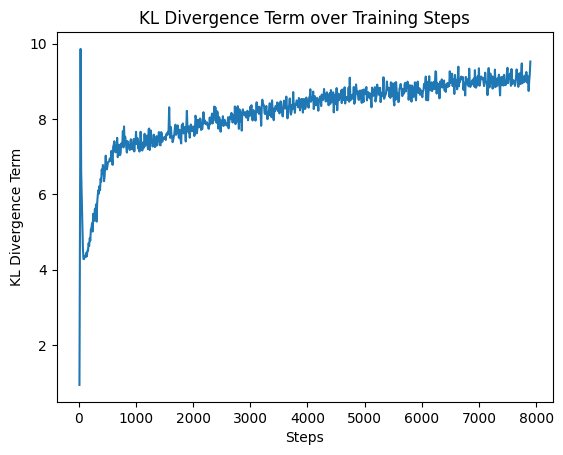

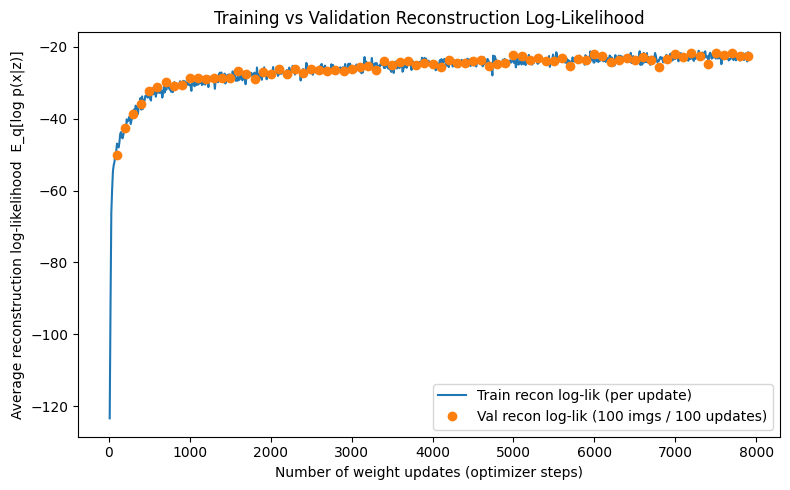

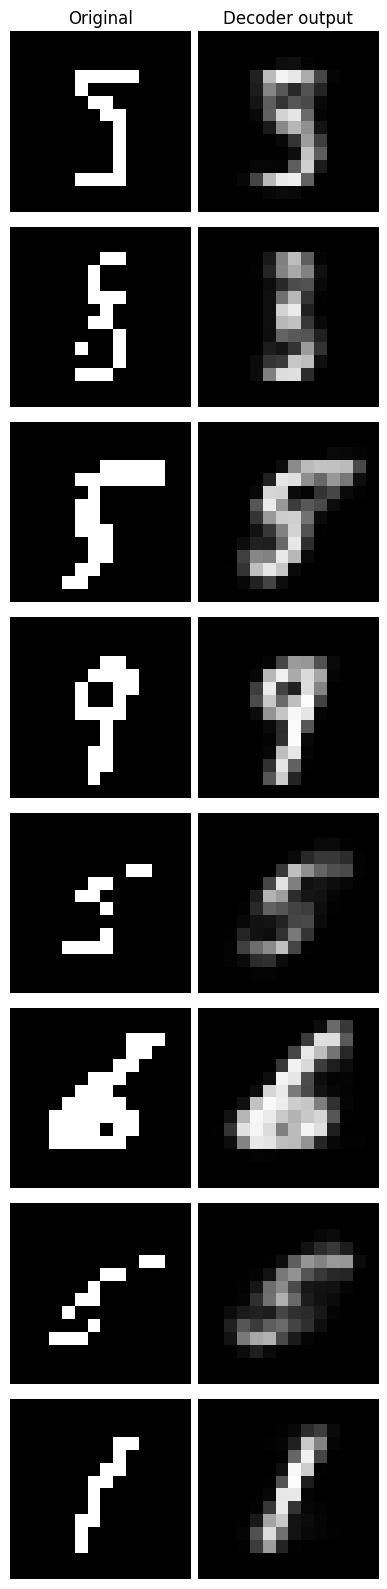

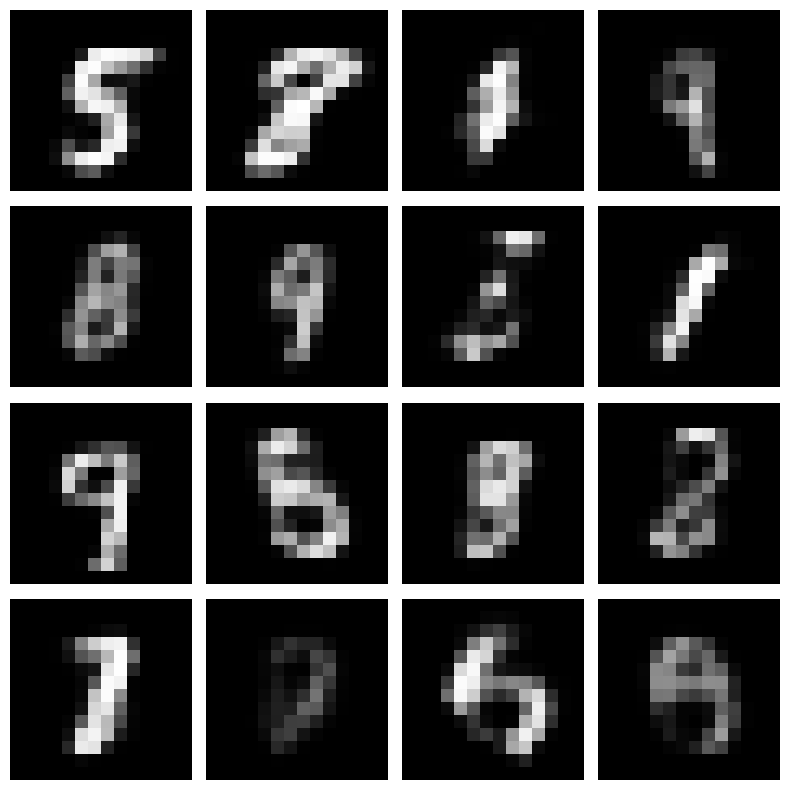

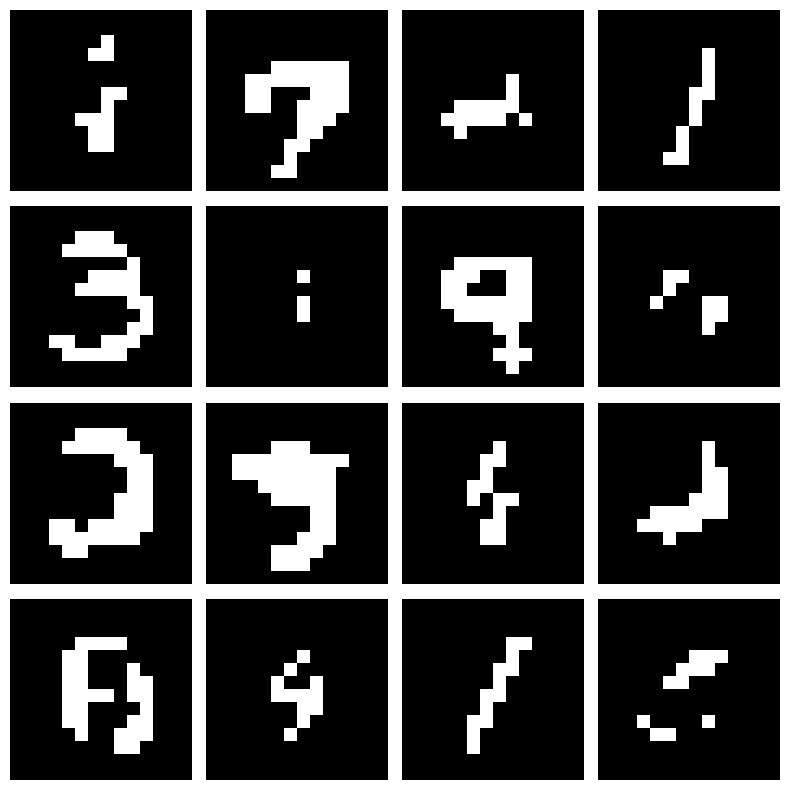

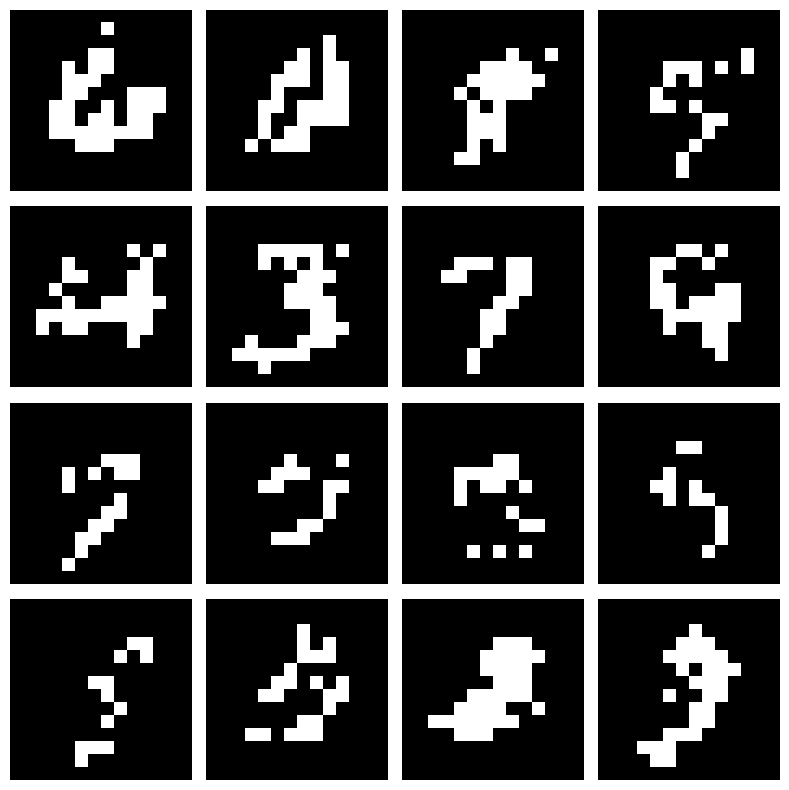

In [2]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange
import numpy as np


def make_mnist_14X14_binarized_10k(root="./data", per_digit = 1000, seed =0):
    thress = 128.0/255.0
    tfm = transforms.Compose([
        transforms.Resize((14, 14)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > thress).float())
    ])

    ds = datasets.MNIST(root=root, train=True, transform=tfm, download=True)
    counts = {d: 0 for d in range(10)}
    picked = []
    all_idx = torch.randperm(len(ds)).tolist()
    for i in all_idx:
        _, y = ds[i]
        y = int(y)
        if counts[y] < per_digit:
            picked.append(i)
            counts[y] +=1
        if all(c == per_digit for c in counts.values()):
            break

    assert len(picked) == 10*per_digit, f"Picked {len(picked)} samples, expected {10*per_digit}"
    subset  = Subset(ds, picked)
    return subset, counts

train_subset, counts = make_mnist_14X14_binarized_10k(per_digit=1000, seed=42)
loader = DataLoader(train_subset, batch_size =128, shuffle = True, num_workers=2, pin_memory=True)

print("Counts per digitL:", counts)
x,y = next(iter(loader))
print("Batch x shape:", x.shape)
print("Unique Pixel values:", torch.unique(x))
print("Labels example:", y[:10])

class VAE(nn.Module):
    def __init__(self, x_dim=14*14, h_dim=128, z_dim=8):
        super().__init__()
        self.enc_fc1 = nn.Linear(x_dim, h_dim)
        self.enc_fc2 = nn.Linear(h_dim, 2*z_dim)
        self.dec_fc1 = nn.Linear(z_dim, h_dim)
        self.dec_fc2 = nn.Linear(h_dim, x_dim)
        self.z_dim = z_dim # Changed from self.z_sim to self.z_dim
        self.x_dim = x_dim

    def encode(self, x):
        h = torch.tanh(self.enc_fc1(x))
        out = self.enc_fc2(h)
        mu = out[:, :self.z_dim]
        logvar = out[:, self.z_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar, K=2):
        sigma = torch.exp(0.5*logvar)
        eps = torch.randn((K,mu.size(0), mu.size(1)), device = mu.device)
        z = mu.unsqueeze(0) + sigma.unsqueeze(0)*eps
        return z

    def decode(self, z):
        if z.dim()==3:
            K, B, _=z.shape
            z_flat=z.reshape(K*B,-1)
            h = torch.tanh(self.dec_fc1(z_flat))
            logits = self.dec_fc2(h)
            y = torch.sigmoid(logits)
            return y.reshape(K, B, -1)
        else:
            h = torch.tanh(self.dec_fc1(z))
            logits = self.dec_fc2(h)
            return torch.sigmoid(logits)

    def forward(self, x, K=2):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, K=K)
        y = self.decode(z)
        return y, mu, logvar

    def elbo_loss(self, x, y, mu, logvar):
        eps = 1e-6
        y_clamped = y.clamp(eps, 1-eps)
        x_expand = x.unsqueeze(0)
        log_px_z = (x_expand * torch.log(y_clamped) + (1 - x_expand) * torch.log(1 - y_clamped)).sum(dim=-1)
        recon = log_px_z.mean(dim=0).mean() # Mean over K samples, then mean over batch
        kl = -0.5*(1+logvar-mu.pow(2)-logvar.exp()).sum(dim=-1)
        kl = kl.mean() # Mean over batch
        loss = -(recon-kl)
        return loss, recon.detach(), kl.detach()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(x_dim=196, h_dim=128, z_dim=8).to(device)
opt = optim.Adam(vae.parameters(), lr = 1e-3)

# def train_epoch(model, loader, opt, K=2):
#     model.train()
#     total_loss, total_recon, total_kl = 0.0, 0.0, 0.0
#     n_batches = 0
#     for xb, _ in loader:
#         xb = xb.to(device).view(xb.size(0), -1)
#         # Correct call to model's forward method
#         yb_pred, mu, logvar = model(xb, K=K)
#         # Correct call to elbo_loss method
#         loss, recon, kl = model.elbo_loss(xb, yb_pred, mu, logvar)
#         opt.zero_grad(set_to_none=True)
#         loss.backward()
#         opt.step()
#         total_loss +=loss.item()
#         total_recon +=recon.item()
#         total_kl +=kl.item()
#         n_batches +=1
#     return total_loss/n_batches, total_recon/n_batches,total_kl/n_batches

# epochs = 20
# for rp in range(1,epochs+1):
#     loss, recon, kl = train_epoch(vae, loader, opt,K=2)
#     print(f"Epoch {rp}: Loss={loss:.4f}, Recon={recon:.4f}, KL={kl:.4f}")

def train_epoch(model, loader, opt, epochs =5, K=2, log_every=1):
    model.train()
    steps=[]
    recon_terms=[]
    kl_terms=[]
    step = 0
    val_steps = []
    val_recon = []
    for ep in trange(epochs):
        for xb, _ in loader:
            xb = xb.to(device).view(xb.size(0), -1)
            # Correct call to model's forward method
            yb_pred, mu, logvar = model(xb, K=K)
            # Correct call to elbo_loss method
            loss, recon, kl = model.elbo_loss(xb, yb_pred, mu, logvar)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            step +=1
            if step % log_every ==0:
                steps.append(step)
                recon_terms.append(recon.item())
                kl_terms.append(kl.item())
            if step % 100 == 0:
                v = avg_loglikelihood(model, loader, K=K)
                val_steps.append(step)
                val_recon.append(v)
    return steps, recon_terms, kl_terms, val_steps, val_recon

def reconstruction(model, loader, K=2):
    model.eval()
    xb, _ = next(iter(loader))
    xb = xb.to(device) # Move xb to the correct device
    # Select the first 8 samples from the batch and flatten them
    xflat = xb[:8].view(8, -1) # Corrected line
    yk, mu, logvar = model(xflat, K=K)
    y_mean = yk.mean(dim=0)
    y_img = y_mean.view(8,14,14).detach().cpu().numpy()
    x_img = xb[:8].view(8, 14, 14).detach().cpu().numpy() # Also use xb[:8] here for consistency
    fig, axes = plt.subplots(8,2, figsize=(4, 16)) # Corrected typo: figssize to figsize
    for i in range(8):
        axes[i,0].imshow(x_img[i], cmap='gray', vmin=0, vmax=1)
        axes[i, 0].axis("off")
        if i == 0:
            axes[i, 0].set_title("Original")
        axes[i, 1].imshow(y_img[i], cmap="gray", vmin=0, vmax=1)
        axes[i, 1].axis("off")
        if i == 0:
            axes[i, 1].set_title("Decoder output")
    plt.tight_layout()
    plt.show()

def sample(model, n=16, mode="prob"):
    model.eval()
    z = torch.randn(n, model.z_dim, device=device)
    y = model.decode(z)
    y_img = y.view(n,14,14)
    if mode =="prob":
        img = y_img
    elif mode =="thresh":
        img = (y_img >0.5).float()
    elif mode =="bern":
        img = torch.bernoulli(y_img)
    else:
        raise ValueError(f"Unknown mode {mode}")
    img = img.detach().cpu().numpy()
    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = np.array(axes).reshape(-1)
    for i in range(rows * cols):
        axes[i].axis("off")
        if i < n:
            axes[i].imshow(img[i], cmap="gray", vmin=0, vmax=1)
    plt.tight_layout()
    plt.show()

def avg_loglikelihood(model, val_loader, K=2):
    model.eval()
    xb, _ = next(iter(val_loader))
    xb = xb.to(device)[:100].view(100, -1)
    yk, mu, logvar = model(xb, K=K)
    eps = 1e-6
    yk = yk.clamp(eps, 1-eps)
    x_expand = xb.unsqueeze(0)
    log_px_z = (x_expand * torch.log(yk) + (1 - x_expand) * torch.log(1 - yk)).sum(dim=-1)
    recon = log_px_z.mean(dim=0).mean() # Mean over K samples, then mean over batch
    return recon.item()


epochs = 100
# for rp in range(1,epochs+1):
steps, recon_terms, kl_terms, val_steps, val_recon = train_epoch(vae, loader, opt, epochs, K=2, log_every=10)
    # print(f"Epoch {rp}: Loss={loss:.4f}, Recon={recon:.4f}, KL={kl:.4f}")
plt.figure()
plt.plot(steps, recon_terms)
plt.xlabel("Steps")
plt.ylabel("Reconstruction Term")
plt.title("Reconstruction Term over Training Steps")
plt.show()
plt.figure()
plt.plot(steps, kl_terms)
plt.xlabel("Steps")
plt.ylabel("KL Divergence Term")
plt.title("KL Divergence Term over Training Steps")
plt.figure(figsize=(8,5))
plt.plot(steps, recon_terms, label="Train recon log-lik (per update)")
plt.plot(val_steps, val_recon, marker="o", linestyle="None", label="Val recon log-lik (100 imgs / 100 updates)")
plt.xlabel("Number of weight updates (optimizer steps)")
plt.ylabel("Average reconstruction log-likelihood  E_q[log p(x|z)]")
plt.title("Training vs Validation Reconstruction Log-Likelihood")
plt.legend()
plt.tight_layout()
plt.show()
reconstruction(vae, loader, K=10)
sample(vae, n=16, mode="prob")
sample(vae, n=16, mode="thresh")
sample(vae, n=16, mode="bern")